# PSPNet으로 시맨틱 분할을 수행한다

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/3. 시맨틱 분할(PSPNet)'

/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/3. 시맨틱 분할(PSPNet)


In [5]:
from utils.dataloader import make_datapath_list, DataTransform

# 파일 경로 리스트 작성
rootpath = "/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/3. 시맨틱 분할(PSPNet)/data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath = rootpath
)

# 나중에 어노테이션 화상만 사용

# 네트워크 준비

In [6]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes = 21)

# 학습된 파라미터를 로드
state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/3. 시맨틱 분할(PSPNet)/weights/pspnet50_30.pth",
                        map_location={'cuda:0' : 'cpu'})
net.load_state_dict(state_dict)

print("네트워크 설정 완료: 학습된 가중치를 로드했습니다.")

네트워크 설정 완료: 학습된 가중치를 로드했습니다.


# 추론 실행

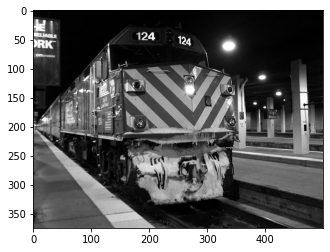

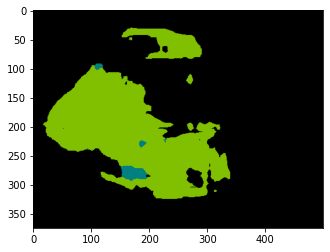

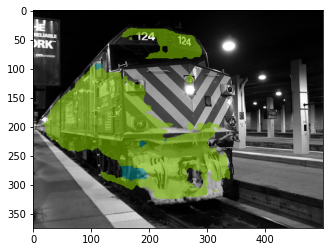

In [7]:
# 1. 원본 화상 표시
image_file_path = '/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/3. 시맨틱 분할(PSPNet)/data/train.jpg'
img = Image.open(image_file_path)   # [높이][폭][색RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 전처리 클래스 작성
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 전처리
# 적당한 어노테이션 화상을 준비하여, 색상 팔레트 정보를 추출
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

# 4. PSPNet으로 추론한다
net.eval()
x = img.unsqueeze(0)  # 미니 배치화: torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss 측은 무시, y의 크기는 torch.Size([1, 21, 475, 475])

# 5. PSPNet의 출력으로 최대 클래스를 구해, 색상 팔레트 형식으로 하여, 화상 크기를 원래대로 되돌린다
y = y[0].detach().numpy()  # y: torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 6. 화상을 투과시켜 겹친다
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # 색상 팔레트 형식을 RGBA로 변환

for x in range(img_width):
    for y in range(img_height):
        # 추론 결과 화상의 픽셀 데이터를 취득
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)의 배경이라면 그대로 투과시킨다
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # 그 외 색상은 준비된 화상에 픽셀을 기록한다
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 투과율을 150으로 지정한다

img = Image.open(image_file_path)   # [높이][폭][색RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()
